<a href="https://colab.research.google.com/github/BoKna031/Image_inpainting/blob/gaussian_cnn/Image_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle dataset

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d amanara/photos

Dataset URL: https://www.kaggle.com/datasets/amanara/photos
License(s): unknown
100% 273M/274M [00:15<00:00, 22.4MB/s]
100% 274M/274M [00:15<00:00, 18.6MB/s]


In [3]:
!unzip photos.zip;

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1252).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1253).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1254).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1255).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1256).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1257).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (126).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1260).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1261).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Train (1262).jpeg  
  inflating: Dataset/Training_Data/Elephant/Unmasked_Train/Elephant-Tr

# Data preparation

In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

TRAIN = 'Train'
TEST = 'Test'
img_size = (64, 64)

def load_training_dataset(category):
  TRAINING_DATA_FOLDER = os.path.join('Dataset', 'Training_Data', category)
  x_doc = os.path.join('Dataset', 'Training_Data', category, 'Masked_Train')
  x_imgs = _load_images_from_folder(x_doc, category, TRAIN)
  y_doc = os.path.join('Dataset', 'Training_Data', category, 'Unmasked_Train')
  y_imgs = _load_images_from_folder(y_doc, category, TRAIN)
  csv_file = pd.read_csv(os.path.join(TRAINING_DATA_FOLDER, 'masked_info.csv'))
  adjust_box_coordinate(csv_file)
  return x_imgs, y_imgs, csv_file

def adjust_box_coordinate(csv_df):
  ORG_IMG_SIZE = (256,256)
  scale_xy = img_size[0] / ORG_IMG_SIZE[0]
  csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] = (csv_df[['box1_row', 'box1_col', 'box2_row', 'box2_col']] * scale_xy).astype(int)


def _load_images_from_folder(folder, category, set_type):
    images = []
    for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, img_size)
            if img is not None:
              id, format = _parse_filename(filename)
              images.append({'filename': filename, 'category': category, 'id': id, 'set_type': set_type, 'format': format, 'image': img})
    images_df = pd.DataFrame(images, columns=['filename', 'category', 'id', 'set_type', 'format', 'image'])
    return images_df

import re

def _parse_filename(filename):
    regex_pattern = r'.*\((\d+)\)\.(\w+)$'

    match = re.match(regex_pattern, filename)

    if match:
        id = int(match.group(1))
        format =  match.group(2)
        return id, format
    else:
        return  None, None

def show_img(img, gray = False):
  if gray:
    plt.imshow(img, 'gray')
  else:
    plt.imshow(img)
  plt.axis('off')
  plt.show()


In [5]:
categories = ['Cat', 'Dog', 'Elephant', 'Tiger']

# Data analyzing

In [82]:
category = categories[0]
_, y, csv = load_training_dataset(category)
x_size = y['image'].apply(lambda img: pd.Series({'rows':img.shape[0], 'cols': img.shape[1]})).groupby(['rows','cols']).size()
print(f"{category}\n---------------------------")
print("total size = ",y.shape[0])
print(x_size)

Cat
---------------------------
total size =  1750
rows  cols
64    64      1750
dtype: int64


From the shown, it can be seen that all the images are of size 168x168

array([[[ 55,  26,  17],
        [ 49,  20,  11],
        [ 47,  18,   9],
        ...,
        [215, 213, 225],
        [200, 198, 210],
        [124, 122, 134]],

       [[ 56,  27,  18],
        [ 53,  24,  15],
        [ 57,  28,  19],
        ...,
        [215, 213, 225],
        [200, 198, 210],
        [121, 119, 131]],

       [[ 52,  23,  14],
        [ 52,  23,  14],
        [ 54,  25,  16],
        ...,
        [216, 214, 226],
        [199, 197, 209],
        [120, 118, 130]],

       ...,

       [[192, 189, 205],
        [184, 181, 197],
        [187, 184, 200],
        ...,
        [191, 188, 204],
        [175, 172, 188],
        [128, 125, 141]],

       [[188, 185, 201],
        [188, 185, 201],
        [193, 190, 206],
        ...,
        [189, 186, 202],
        [177, 174, 190],
        [129, 126, 142]],

       [[182, 179, 195],
        [194, 191, 207],
        [205, 202, 218],
        ...,
        [193, 190, 206],
        [185, 182, 198],
        [127, 124, 140]]], dtype=uint8)
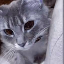

In [83]:
y.iloc[0]['image']

In [84]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col
0,0,Cat-Train (1085).jpeg,16,1,10,38
1,1,Cat-Train (900).jpeg,21,5,26,41
2,2,Cat-Train (1759).jpeg,15,24,0,35
3,3,Cat-Train (969).jpeg,3,34,11,34
4,4,Cat-Train (1559).jpeg,26,23,10,39


In [85]:
box_size = [15, 15]

def is_within_bounds(row, col):
  return row + box_size[0] <= img_size[0] and col + box_size[1] <= img_size[1]

In [86]:
csv['box1_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box1_row'], row['box1_col']), axis=1)
csv['box2_within_bounds'] = csv.apply(lambda row: is_within_bounds(row['box2_row'], row['box2_col']), axis=1)
invalid_boxes = csv[(~csv['box1_within_bounds']) | (~csv['box2_within_bounds'])]

In [87]:
csv.head()

,Unnamed: 0,filename,box1_row,box1_col,box2_row,box2_col,box1_within_bounds,box2_within_bounds
0,0,Cat-Train (1085).jpeg,16,1,10,38,True,True
1,1,Cat-Train (900).jpeg,21,5,26,41,True,True
2,2,Cat-Train (1759).jpeg,15,24,0,35,True,True
3,3,Cat-Train (969).jpeg,3,34,11,34,True,True
4,4,Cat-Train (1559).jpeg,26,23,10,39,True,True


In [88]:
print(f"There is {invalid_boxes.shape[0]} images that have invalid boxes")

There is 0 images that have invalid boxes


In [89]:
x_cp = y.copy(deep=True)

In [90]:
def img_normalize(image_orig, min_norm, max_norm):
    val_max = 255.0
    val_min = 0.0
    range = val_max - val_min
    image_normalized = (image_orig - val_min) / range
    range2 = max_norm - min_norm
    image_normalized = (image_normalized*range2) + min_norm
    return image_normalized

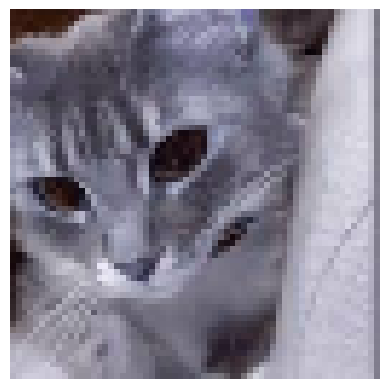

In [91]:
show_img(img_normalize(x_cp.iloc[0]['image'], 0, 1))

In [92]:
import numpy as np
def draw_masks(image, csv_row , box_size):
    col1, row1, col2, row2 = csv_row['box1_col'], csv_row['box1_row'], csv_row['box2_col'], csv_row['box2_row']

    mask = np.zeros(img_size)
    mask[row1:row1+box_size[0], col1:col1+box_size[1]] = 1
    img_cp = image.copy()

    #gaussian
    gaussian_noise = np.random.normal(0, 1, img_cp.shape)
    mean_pixel_value = np.mean(image, axis=(0, 1), keepdims=True)
    noise_centered_at_mean = mean_pixel_value + gaussian_noise

    img_cp[mask == 1] = gaussian_noise[mask == 1]

    img_cp = img_normalize(img_cp, 0, 1)

    mask = mask[:, :, np.newaxis]
    rgbm_image = np.concatenate((img_cp, mask), axis=2)

    return rgbm_image

In [93]:
x_cp['image'] = x_cp.apply(lambda row: draw_masks(row['image'], csv[csv['filename'] == row['filename']].iloc[0], box_size), axis = 1)

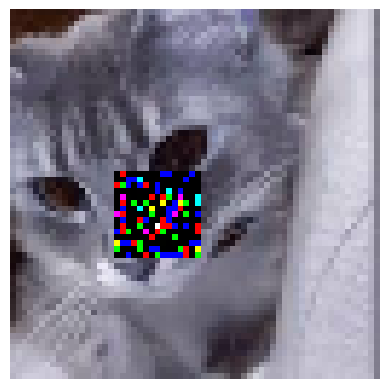

In [94]:
show_img(x_cp.iloc[0]['image'][:,:,:3])

In [95]:
merged_data = pd.merge(x_cp, csv, on='filename')
merged_data = pd.merge(merged_data, y, on = 'filename')

In [96]:
final_table_columns = ['filename', 'image_x', 'image_y', 'box2_row', 'box2_col']
train_df = merged_data.drop(columns=[col for col in merged_data if col not in final_table_columns])

In [97]:
#train_df.head()

In [98]:
test_row = train_df.iloc[3]
x_coord, y_coord = test_row['box2_row'], test_row['box2_col']
print(x_coord, y_coord)

37 5


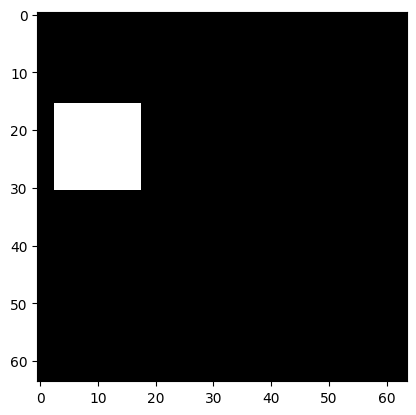

In [99]:
plt.imshow(test_row['image_x'][:,:,3], cmap='gray')
plt.show()

In [100]:
def crop_box(rgbm, y_img):
  mask = rgbm[:,:,3]
  rows, cols = np.where(mask == 1)

  min_row, max_row = np.min(rows), np.max(rows)
  min_col, max_col = np.min(cols), np.max(cols)

  return y_img[min_row:max_row + 1, min_col:max_col + 1, :]


In [101]:
train_df['image_y'] = train_df.apply(lambda row: img_normalize(crop_box(row['image_x'], row['image_y']), 0, 1), axis = 1)

# Networks

In [46]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras.models import Sequential

## CNN

In [47]:
euclidean_model_1 = Sequential()

euclidean_model_1.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 4)))
for i in range(9):
  if (i + 1) % 3 == 0:
     euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    euclidean_model_1.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

euclidean_model_1.add(Flatten())
euclidean_model_1.add(Dense(box_size[0]*box_size[1]*3, activation='relu'))
euclidean_model_1.add(Activation('sigmoid'))
euclidean_model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [48]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

def lr_schedule(epoch):
  model = euclidean_model_1 #change before model fit
  lr = K.get_value(model.optimizer.lr)
  if epoch % 5 == 0 and epoch > 0:
      K.set_value(model.optimizer.lr, lr * 0.8)
      print(f"Learning rate reduced to: {lr * 0.8}")
  return K.get_value(model.optimizer.lr)

batch_size = 64
weight_decay = 0.005
lr_scheduler = LearningRateScheduler(lr_schedule)

In [28]:
#train_df.iloc[0]['image_x']

In [49]:
print(type(train_df.iloc[0]['image_y']))
print(train_df.iloc[0]['image_y'].shape)

<class 'numpy.ndarray'>
(15, 15, 3)


In [50]:
lr_scheduler = LearningRateScheduler(lr_schedule)
batch_size = 16
epochs = 5

In [102]:
X_train = np.stack(train_df['image_x'].values)
y_train = np.stack(train_df['image_y'].values)
y_train = y_train.reshape(y_train.shape[0],box_size[0]*box_size[1]*3)

In [52]:
print('x: ', np.max(X_train))
print('y: ', np.max(y_train))

x:  1.0
y:  1.0


In [33]:
#X_train = X_train / 255.0
#y_train = y_train / 255.0

In [53]:
history = euclidean_model_1.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[lr_scheduler],
    validation_split=0.2
)



Epoch 1/5
88/88 [==============================] - 105s 1s/step - loss: 0.0751 - mae: 0.2326 - val_loss: 0.0721 - val_mae: 0.2286 - lr: 0.0010
Epoch 2/5
88/88 [==============================] - 103s 1s/step - loss: 0.0708 - mae: 0.2245 - val_loss: 0.0670 - val_mae: 0.2198 - lr: 0.0010
Epoch 3/5
88/88 [==============================] - 102s 1s/step - loss: 0.0673 - mae: 0.2170 - val_loss: 0.0680 - val_mae: 0.2145 - lr: 0.0010
Epoch 4/5
88/88 [==============================] - 102s 1s/step - loss: 0.0650 - mae: 0.2113 - val_loss: 0.0622 - val_mae: 0.2066 - lr: 0.0010
Epoch 5/5
88/88 [==============================] - 106s 1s/step - loss: 0.0639 - mae: 0.2088 - val_loss: 0.0625 - val_mae: 0.2065 - lr: 0.0010


In [54]:
import pickle

def save_history(history, path):
  with open(path, 'wb') as f:
    pickle.dump(history, f)

In [55]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/trained-models"
HISTORY_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CNN/history"

In [56]:
euclidean_model_1.save(MODEL_PATH + "/euclidean_model_1.keras")
save_history(history.history, HISTORY_PATH + "/euclidean_model_64_history.pkl")

# Monitoring - History of loss function

In [57]:
def load_history(path):
  with open(path, "rb") as file:
    return pickle.load(file)

In [58]:
h1 = load_history(HISTORY_PATH + "/euclidean_model_64_history.pkl")

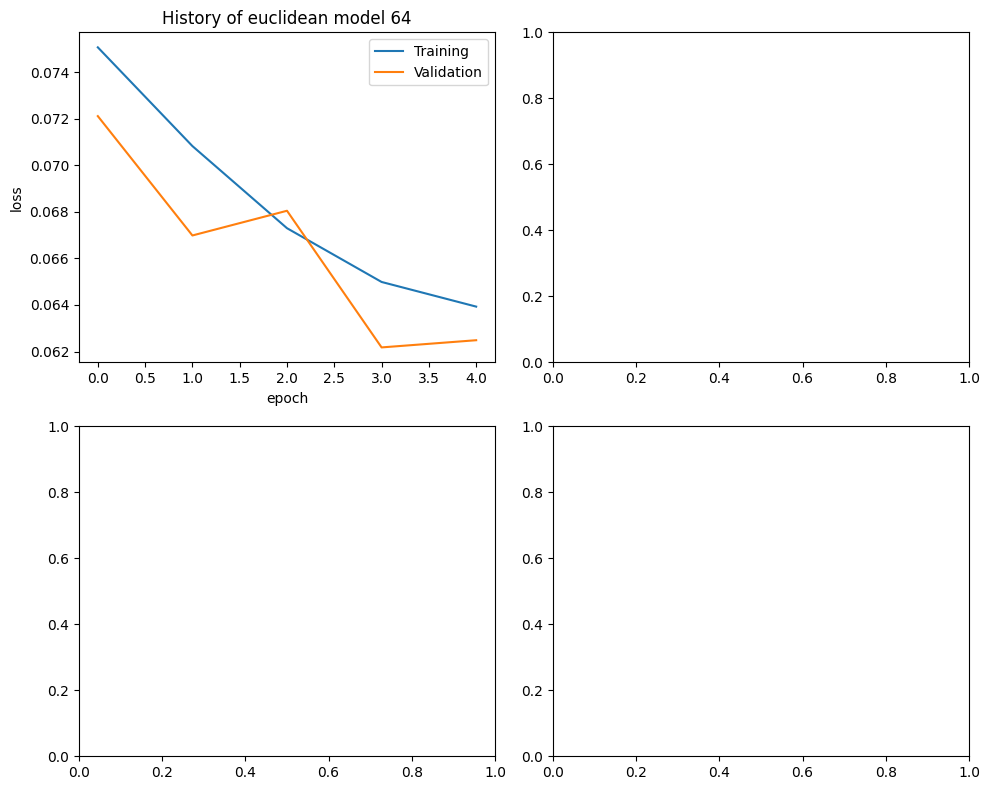

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(h1['loss'])
axes[0, 0].plot(h1['val_loss'])
axes[0, 0].set_title('History of euclidean model 64')
axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_ylabel('loss')
axes[0, 0].legend(['Training', 'Validation'])
plt.tight_layout()
plt.show()

# Predictions

In [60]:
from keras.models import load_model

euc1_model = load_model(MODEL_PATH + "/euclidean_model_1.keras")

In [103]:
x = X_train[0:5]

In [104]:
pred = euc1_model.predict(x)

1/1 [==============================] - 0s 104ms/step


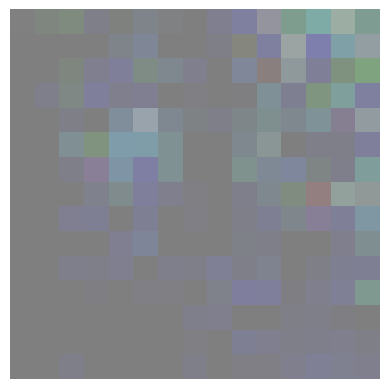

In [105]:
show_img(np.reshape(pred[4], (15, 15, 3)))

In [106]:
def full_image(x_rgbm_img, y_img):
  modified_image = np.copy(x_rgbm_img[:, :, :3])
  mask = x_rgbm_img[:,:,3]

  coords = np.argwhere(mask == 1)

  x_min = np.min(coords[:, 0])
  y_min = np.min(coords[:, 1])

  modified_image[x_min:x_min+box_size[0], y_min:y_min+box_size[1], :] = y_img

  return modified_image

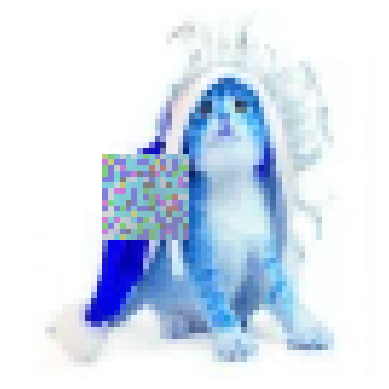

In [109]:
img_ind = 1
show_img(full_image(x[img_ind],np.reshape(pred[img_ind], (15, 15, 3))))